# Assignment 11 - Arun Kutty


## Final Test Accuracy - 85.50


## Script Parameters


In [41]:
# git repository url
repo_name = "ERAV2-S11"
git_repo_url = "https://github.com/ArunNKutty/ERAV2-S11.git"

# WHich branch are you working on?
branch_name = "main"

## Library Installation (Optional)


In [2]:
import sys
    # !{sys.executable} -m pip install torchsummary
!{sys.executable} -m pip install torch-lr-finder
!{sys.executable} -m pip install torchinfo
    # https://github.com/jacobgil/pytorch-grad-cam
!{sys.executable} -m pip install grad-cam

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

## Code Procurement


In [42]:
import sys
import os

# Current working directory
print(f"CWD: {os.getcwd()}")


!rm -rf {repo_name} && git clone {git_repo_url}

    # Switch to repo folder, Needed to switch branch
    # Switch branch and change to the correct directory
!cd "{repo_name}" && git checkout {branch_name}

#     # Make custom modules available
print(f"Appending folder to path in order to detect modules:")
sys.path.append(f"ERAV2-S11")

CWD: /content
Cloning into 'ERAV2-S11'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 93 (delta 38), reused 80 (delta 25), pack-reused 0
Receiving objects: 100% (93/93), 334.87 KiB | 4.29 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Already on 'main'
Your branch is up to date with 'origin/main'.
Appending folder to path in order to detect modules:


## Import Libraries


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# Import necessary modules (external libs)
import os

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder

# from torchsummary import summary

In [ ]:
!ls
!cd ERAV2-S11


ERAV2-S11  sample_data


In [44]:
!pip install torchmetrics

In [45]:
# Import user defined modules
from models.resnet import ResNet18 as Net
from models.resnet import detailed_model_summary
from modules.dataset import CIFAR_CLASSES, get_cifar_dataloaders
from modules.trainer import find_optimal_lr, train_and_test_model
from modules.utils import get_device, get_num_workers, pretty_print_metrics, save_model
from modules.visualize import (
    plot_gradcam_images,
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

## Script Parameters


In [32]:
# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Where do we store the data?
data_path = "../../data"

# Specify the number of epochs
NUM_EPOCHS = 20

# Set the batch size
BATCH_SIZE = 512

# What is the start LR and weight decay you'd prefer?
PREFERRED_START_LR = 3e-2
PREFERRED_WEIGHT_DECAY = 1e-5

# Set seed value for reproducibility
SEED = 26

# Expected accuracy
TARGET_ACCURACY = 85.0


## Get Device


In [31]:
device_support, device = get_device()

# How many workers do you need?
num_workers = get_num_workers("colab")

print(
    # f"Run location: {"colab"}, \n",
    f"Device: {device_support}, \n",
    f"Number of workers: {num_workers}, \n",
    f"Batch size: {BATCH_SIZE} \n",
    f"Seed: {SEED} \n",
    f"Data path: {data_path}",
)


Device: cuda, 
 Number of workers: 2, 
 Batch size: 512 
 Seed: 26 
 Data path: ../../data


### Reproducibility settings


In [33]:
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

if device_support == "cuda":
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

## Data Loaders

> Add blockquote




In [34]:
# Get the train and test loader
# Transformations for the train and test data is present in dataset.py
train_loader, test_loader = get_cifar_dataloaders(
    data_path=data_path, batch_size=BATCH_SIZE, num_workers=num_workers, seed=SEED
)

# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(f"Class Labels: {classes}")



Files already downloaded and verified
Files already downloaded and verified

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]

Transforms applied on the dataset

Class Labels: ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')




```
# This is formatted as code
```

## Sample Training Images


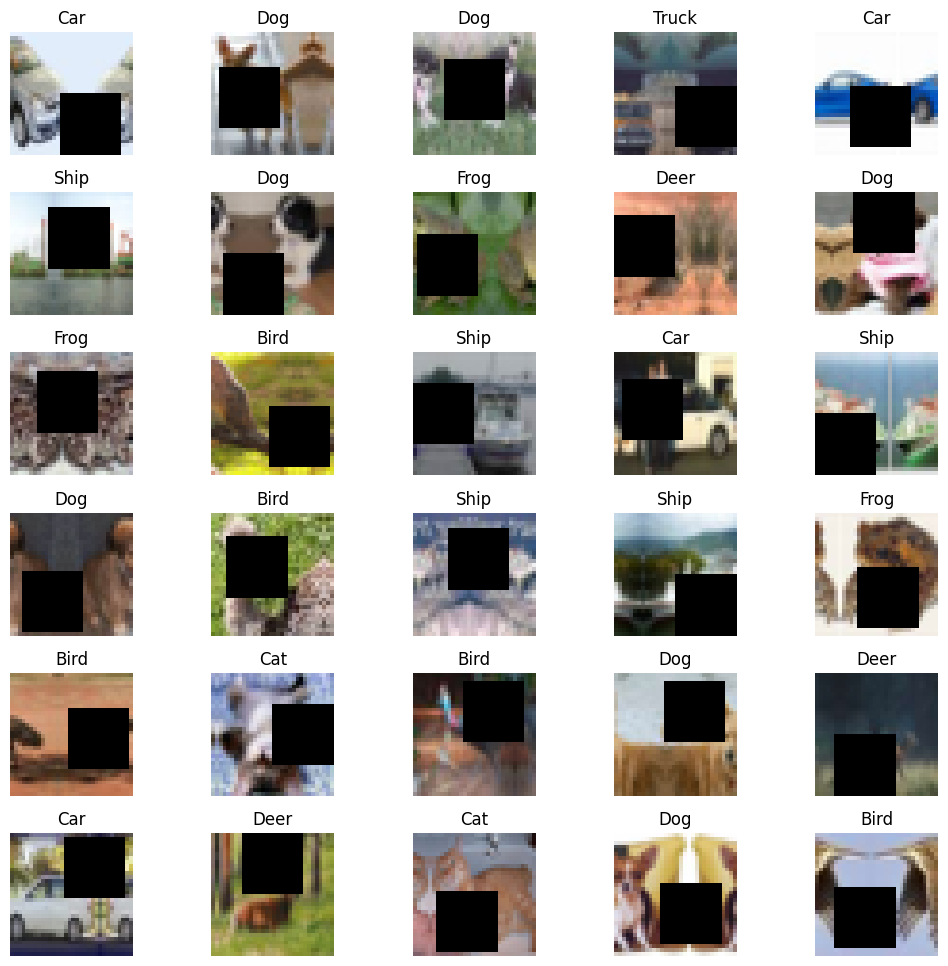

In [35]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(batch_data, batch_label, class_label=classes, num_images=30)
plt.show()

## Model Summary

In [36]:
# Model class is imported from model.py

# Send the model to device
model = Net().to(device)

# enable printing shape
model.print_shape = True

# # Print the model summary by specifying the input size
# summary(model, input_size=(3, 32, 32))
detailed_model_summary(model, input_size=(3, 32, 32), device=device)

# disable printing shape for cleaner test train output
model.print_shape = False

Layer (type:depth-idx)                   Input Shape      Kernel Shape     Output Shape     Param #          Trainable
ResNet                                   [1, 3, 32, 32]   --               [1, 10]          --               True
├─Conv2d: 1-1                            [1, 3, 32, 32]   [3, 3]           [1, 64, 32, 32]  1,728            True
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]  --               [1, 64, 32, 32]  128              True
├─Sequential: 1-3                        [1, 64, 32, 32]  --               [1, 64, 32, 32]  --               True
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]  --               [1, 64, 32, 32]  --               True
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]  [3, 3]           [1, 64, 32, 32]  36,864           True
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]  --               [1, 64, 32, 32]  128              True
│    │    └─Conv2d: 3-3                  [1, 64, 32, 32]  [3, 3]           [1, 64, 

## Train and Test

## Optimizer and Loss Function


In [37]:
# Create optimizer and scheduler
# Use ADAM
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = optim.Adam(model.parameters(), lr=PREFERRED_START_LR, weight_decay=PREFERRED_WEIGHT_DECAY)

# Define criteria function
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss()


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.07E-02


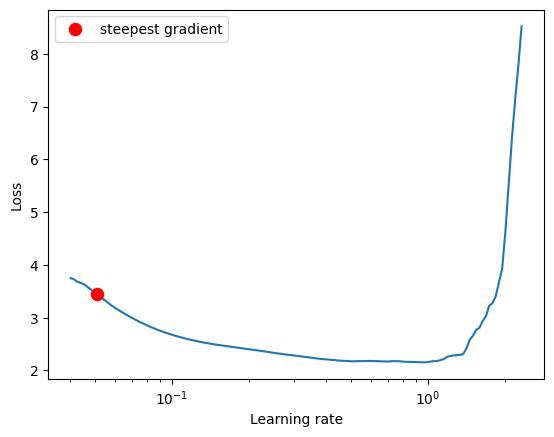

In [ ]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.63E-02


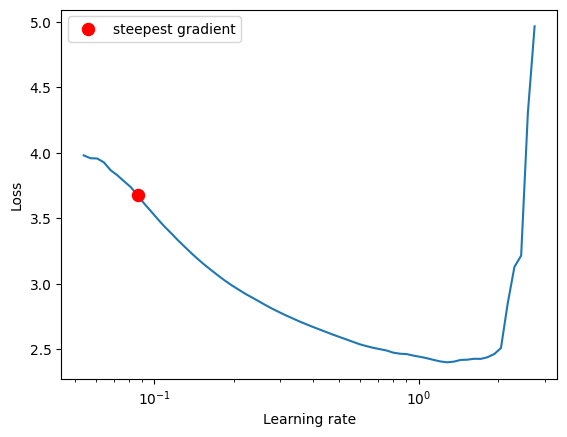

In [17]:
# Find optimal LR to start with
suggested_lr = find_optimal_lr(model, optimizer, criterion, train_loader)




```
# This is formatted as code
```

## Scheduler


In [38]:
# suggested_lr = 0.2
print(f"Suggested Max LR: {suggested_lr}")

# Learning rate scheduler based on OneCycleLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = OneCycleLR(
    optimizer,
    max_lr=suggested_lr,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=5 / NUM_EPOCHS,
    div_factor=100,
    three_phase=False,
    anneal_strategy="linear",
    final_div_factor=100,
    verbose=False,
)

Suggested Max LR: 0.08626338205031817


## Train and Test Model

In [19]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for NUM_EPOCHS
results = train_and_test_model(
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    misclassified_image_data=misclassified_image_data,
)



Batch size: 512, Total epochs: 20


Epoch 1


Train: Loss=1.4376, Batch_id=97, Accuracy=36.77: 100%|██████████| 98/98 [00:37<00:00,  2.64it/s]


Test set: Average loss: 0.0029,  Accuracy: 4671/10000  (46.71%)


Epoch 2


Train: Loss=1.1599, Batch_id=97, Accuracy=49.81: 100%|██████████| 98/98 [00:38<00:00,  2.55it/s]


Test set: Average loss: 0.0026,  Accuracy: 5418/10000  (54.18%)


Epoch 3


Train: Loss=1.1248, Batch_id=97, Accuracy=55.95: 100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


Test set: Average loss: 0.0024,  Accuracy: 5867/10000  (58.67%)


Epoch 4


Train: Loss=1.0624, Batch_id=97, Accuracy=59.99: 100%|██████████| 98/98 [00:39<00:00,  2.46it/s]


Test set: Average loss: 0.0025,  Accuracy: 5527/10000  (55.27%)


Epoch 5


Train: Loss=1.0773, Batch_id=97, Accuracy=63.44: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0021,  Accuracy: 6581/10000  (65.81%)


Epoch 6


Train: Loss=0.8551, Batch_id=97, Accuracy=66.37: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0019,  Accuracy: 6758/10000  (67.58%)


Epoch 7


Train: Loss=0.8393, Batch_id=97, Accuracy=68.61: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0020,  Accuracy: 6545/10000  (65.45%)


Epoch 8


Train: Loss=0.8072, Batch_id=97, Accuracy=70.94: 100%|██████████| 98/98 [00:39<00:00,  2.46it/s]


Test set: Average loss: 0.0017,  Accuracy: 7127/10000  (71.27%)


Epoch 9


Train: Loss=0.7498, Batch_id=97, Accuracy=71.83: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0017,  Accuracy: 7155/10000  (71.55%)


Epoch 10


Train: Loss=0.7629, Batch_id=97, Accuracy=73.35: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0013,  Accuracy: 7775/10000  (77.75%)


Epoch 11


Train: Loss=0.8205, Batch_id=97, Accuracy=74.64: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0020,  Accuracy: 6851/10000  (68.51%)


Epoch 12


Train: Loss=0.6725, Batch_id=97, Accuracy=75.84: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0014,  Accuracy: 7671/10000  (76.71%)


Epoch 13


Train: Loss=0.6006, Batch_id=97, Accuracy=77.35: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0011,  Accuracy: 8128/10000  (81.28%)


Epoch 14


Train: Loss=0.6097, Batch_id=97, Accuracy=78.21: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0014,  Accuracy: 7881/10000  (78.81%)


Epoch 15


Train: Loss=0.6902, Batch_id=97, Accuracy=78.74: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0013,  Accuracy: 7938/10000  (79.38%)


Epoch 16


Train: Loss=0.4919, Batch_id=97, Accuracy=79.67: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0009,  Accuracy: 8500/10000  (85.00%)


Epoch 17


Train: Loss=0.5497, Batch_id=97, Accuracy=80.17: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0014,  Accuracy: 7926/10000  (79.26%)


Epoch 18


Train: Loss=0.6258, Batch_id=97, Accuracy=80.95: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0012,  Accuracy: 8086/10000  (80.86%)


Epoch 19


Train: Loss=0.5625, Batch_id=97, Accuracy=80.97: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0020,  Accuracy: 7142/10000  (71.42%)


Epoch 20


Train: Loss=0.5705, Batch_id=97, Accuracy=81.74: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0009,  Accuracy: 8543/10000  (85.43%)




In [20]:
# Pretty print train and test accuracy and loss values for each epoch
pretty_print_metrics(num_epochs=NUM_EPOCHS, results=results)


Epoch: 01, Train Loss: 1.7121, Test Loss: 0.0029, Train Accuracy: 36.7680, Test Accuracy: 46.7100
Epoch: 02, Train Loss: 1.3775, Test Loss: 0.0026, Train Accuracy: 49.8060, Test Accuracy: 54.1800
Epoch: 03, Train Loss: 1.2121, Test Loss: 0.0024, Train Accuracy: 55.9460, Test Accuracy: 58.6700
Epoch: 04, Train Loss: 1.1119, Test Loss: 0.0025, Train Accuracy: 59.9860, Test Accuracy: 55.2700
Epoch: 05, Train Loss: 1.0147, Test Loss: 0.0021, Train Accuracy: 63.4360, Test Accuracy: 65.8100
Epoch: 06, Train Loss: 0.9443, Test Loss: 0.0019, Train Accuracy: 66.3720, Test Accuracy: 67.5800
Epoch: 07, Train Loss: 0.8888, Test Loss: 0.0020, Train Accuracy: 68.6100, Test Accuracy: 65.4500
Epoch: 08, Train Loss: 0.8271, Test Loss: 0.0017, Train Accuracy: 70.9420, Test Accuracy: 71.2700
Epoch: 09, Train Loss: 0.8008, Test Loss: 0.0017, Train Accuracy: 71.8340, Test Accuracy: 71.5500
Epoch: 10, Train Loss: 0.7606, Test Loss: 0.0013, Train Accuracy: 73.3540, Test Accuracy: 77.7500
Epoch: 11, Train Los

## Metrics


Expected accuracy: 85.0%
Plotting accuracy and loss graphs.


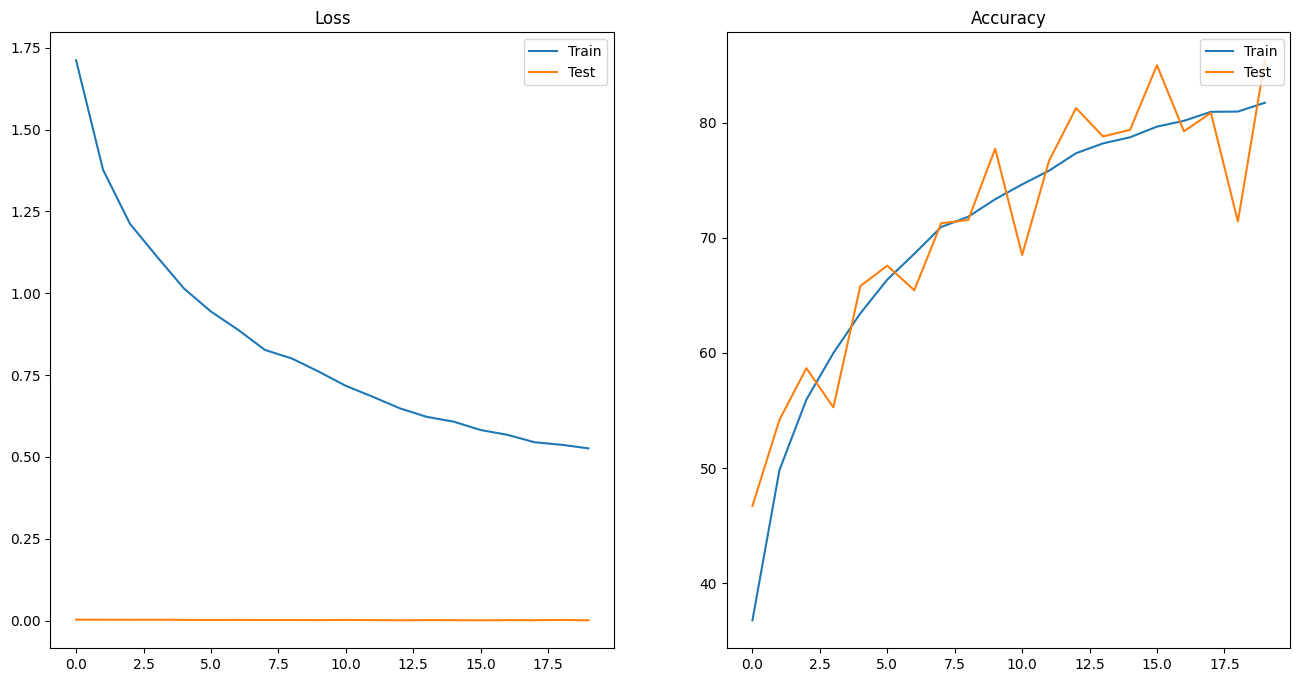

In [21]:
# Print expected accuracy for easier reference
print(f"Expected accuracy: {TARGET_ACCURACY}%")

# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()
# plt.savefig("Loss and Accuracy Metrics.png")

## Save Model

In [22]:
# Save model
print("Saving the model as the training is complete!")
save_model(
    epoch=NUM_EPOCHS,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=BATCH_SIZE,
    criterion=criterion,
    file_name="model_last_epoch.pth",
)


Saving the model as the training is complete!


## Show Misclassified Images

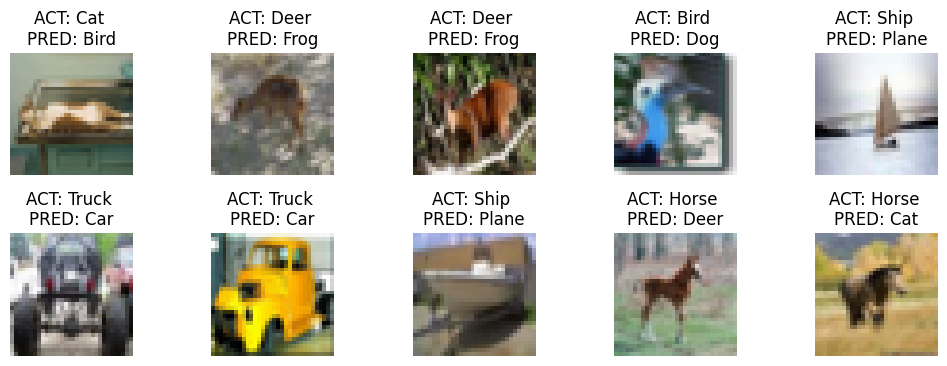

In [39]:
# Plot misclassified images
fig, axs = plot_misclassified_images(data=misclassified_image_data, class_label=classes, num_images=10)
plt.show()
# plt.savefig("Misclassified Images.png")


## Grad Cam (Misclassified)


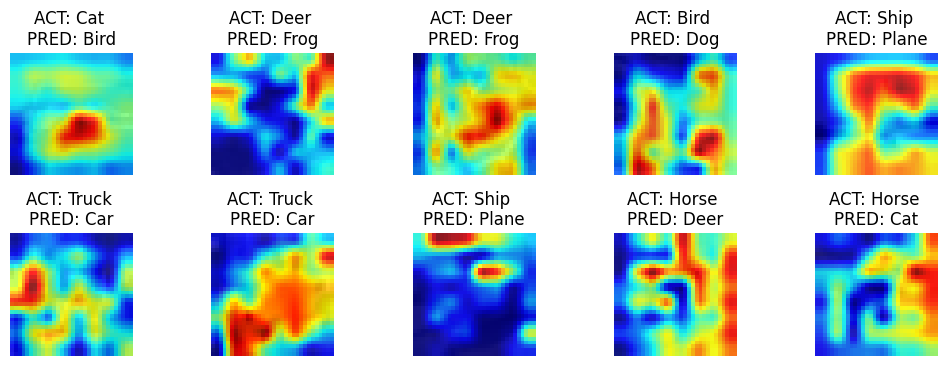

In [56]:
# Plot misclassified images
fig, axs = plot_gradcam_images(
    model=model,
    data=misclassified_image_data,
    class_label=classes,
    # Use penultimate block of resnet18 layer 3 as the target layer for gradcam
    # Decided using model summary so that dimensions > 7x7
    target_layers=[model.layer3[-1]],
    device=device_support,
    targets=None,
    num_images=10,
    image_weight=0.15,
)
plt.show()
# plt.savefig("GradCAM Images.png")


